## SimpleNet Implementation

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from models import SimpleNet, ResNetModel
from GazeMapDataset import GazeMapDataset
import utils
import matplotlib.pyplot as plt
import random

### Data Preparation

In [59]:
# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

map_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean=0.5 and std=0.5
])

# Directories for train and validation
train_images_dir = 'data/datasets_0221/correct/images/train'
train_maps_dir = 'data/datasets_0221/correct/maps/train'
val_images_dir = 'data/datasets_0221/correct/images/val'
val_maps_dir = 'data/datasets_0221/correct/maps/val'
# Create datasets
train_dataset = GazeMapDataset(train_images_dir, train_maps_dir, image_transform=image_transform, map_transform=map_transform, split='train')
val_dataset = GazeMapDataset(val_images_dir, val_maps_dir, image_transform=image_transform, map_transform=map_transform, split='val')
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
len(val_dataset)

2714

In [60]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-4

model = ResNetModel(train_enc=False).cuda()
#criterion = nn.KLDivLoss(reduction='batchmean')
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

/home/souptik/anaconda3/envs/simplenet/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/souptik/anaconda3/envs/simplenet/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40):
    best_val_loss = float('inf')
    best_model_weights = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, gaze_maps in train_loader:
            B, C, H, W = images.shape
            images = images.cuda()
            gaze_maps = gaze_maps.cuda()
            
            optimizer.zero_grad()
            outputs = model(images).reshape(B, 1, H, W)
            
            #outputs = F.log_softmax(outputs, dim=1)
            #gaze_maps = F.normalize(gaze_maps, p=1, dim=1)
            
            loss = criterion(outputs, gaze_maps)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()

    # Load the best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        torch.save(model.state_dict(), 'best_simplenet_model.pth')


In [62]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, gaze_maps in val_loader:
            B, C, H, W = images.shape
            images = images.cuda()
            gaze_maps = gaze_maps.cuda()
            outputs = model(images).reshape(B, 1, H, W)
            loss = criterion(outputs, gaze_maps)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

In [ ]:
import random
import matplotlib.pyplot as plt

path = "best_simplenet_model_l1.pth"

def visualize_random_result(model, val_loader):
    state_dict = torch.load(path)
    model = ResNetModel().cuda() 
    model.load_state_dict(state_dict)

    model.eval()
    
    data_iter = iter(val_loader)
    num_batches = len(val_loader)
    random_batch_idx = random.randint(0, num_batches - 1)
    
    for _ in range(random_batch_idx):
        images, gaze_maps = next(data_iter)
    
    batch_size = images.size(0)
    random_image_idx = random.randint(0, batch_size - 1)
    
    image = images[random_image_idx].unsqueeze(0).cuda()
    true_gaze_map = gaze_maps[random_image_idx].unsqueeze(0)
    
    with torch.no_grad():
        predicted_gaze_map = model(image)
    
    image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
    predicted_gaze_map = predicted_gaze_map.cpu().numpy().squeeze()
    true_gaze_map = true_gaze_map.cpu().numpy().squeeze()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(image)
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    
    axs[1].imshow(true_gaze_map, cmap='gray')
    axs[1].set_title('True Gaze Map')
    axs[1].axis('off')
    
    axs[2].imshow(predicted_gaze_map, cmap='gray')
    axs[2].set_title('Predicted Gaze Map')
    axs[2].axis('off')
    
    plt.show()

visualize_random_result(model, val_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


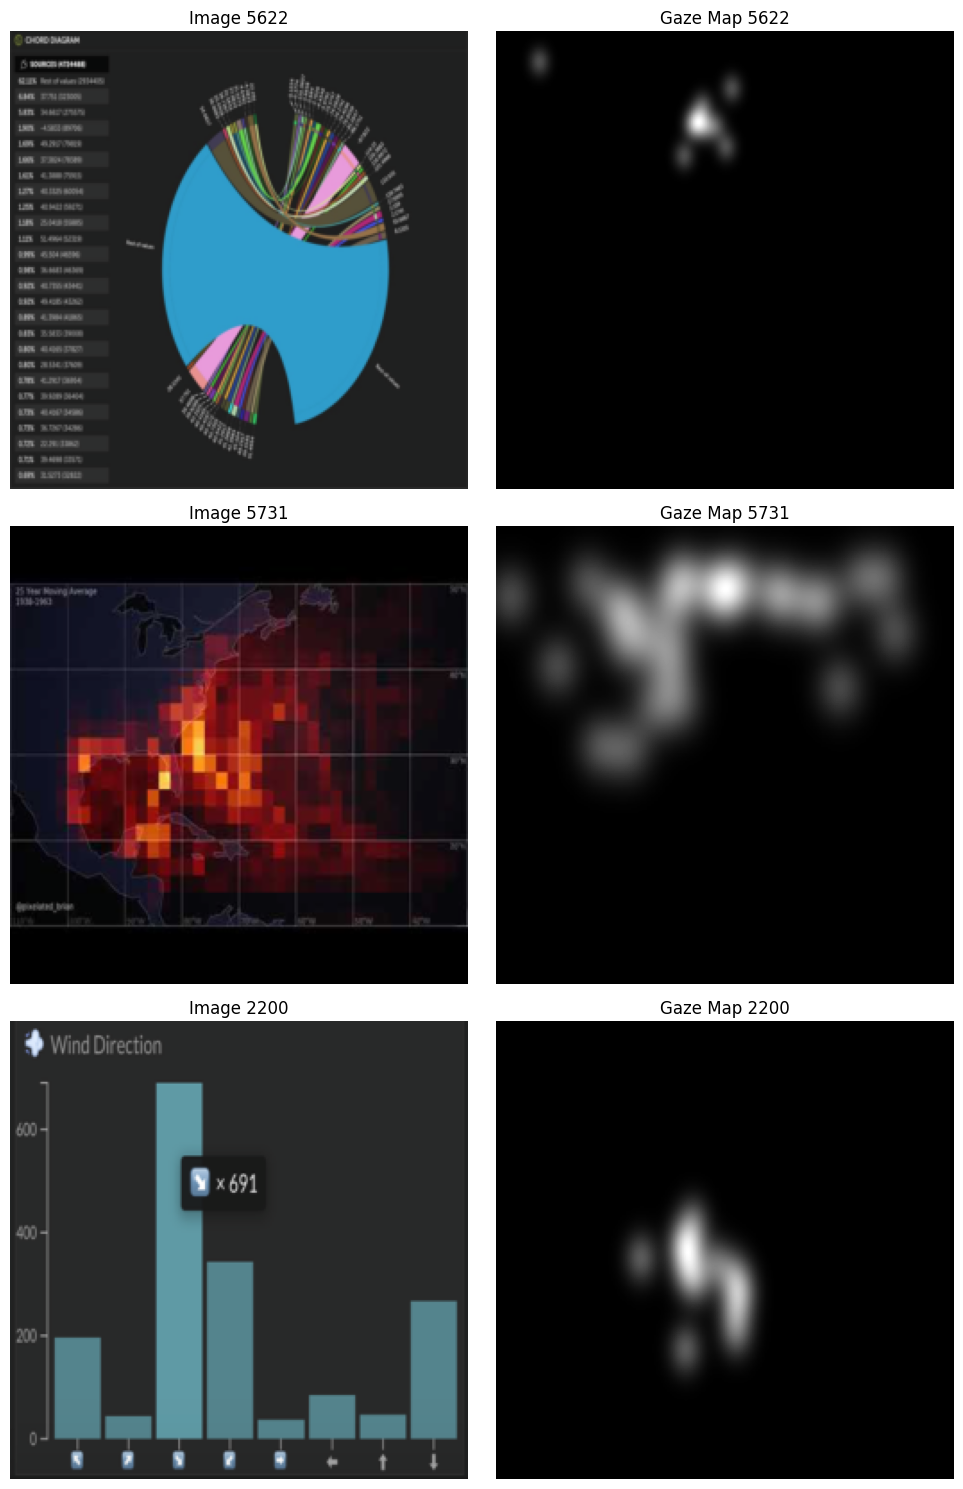

In [64]:
def visualize_sample_images_maps(dataset, num_samples=3):
    """
    Visualizes random samples of images and their corresponding gaze maps.
    
    :param dataset: The dataset object containing image-map pairs.
    :param num_samples: Number of samples to visualize. Default is 3.
    """
    num_samples = min(num_samples, len(dataset))
    
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i, idx in enumerate(sample_indices):
        image, gaze_map = dataset[idx]
        
        image_np = image.permute(1, 2, 0).numpy() 
        image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406] 
        
        gaze_map_np = gaze_map.squeeze().numpy()  
        
        axs[i, 0].imshow(image_np)
        axs[i, 0].set_title(f"Image {idx}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(gaze_map_np, cmap='gray')
        axs[i, 1].set_title(f"Gaze Map {idx}")
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_sample_images_maps(train_dataset, num_samples=3)

In [65]:

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)
evaluate_model(model, val_loader, criterion)

Epoch [1/40], Train Loss: 0.0508, Val Loss: 0.0455
Epoch [2/40], Train Loss: 0.0455, Val Loss: 0.0455
Epoch [3/40], Train Loss: 0.0455, Val Loss: 0.0455
Epoch [4/40], Train Loss: 0.0455, Val Loss: 0.0455


In [ ]:
visualize_results(model, val_loader)